In [1]:
import mne
import numpy as np
import glob
import os
from timeit import default_timer
import pandas as pd
from scipy.linalg import eigh
import numpy.matlib as npm
import matplotlib.pyplot as plt
from matplotlib import gridspec

### Reading EEG Data Using MNE

This code reads EEG data from a .set file, prints basic info, and plots the data.

Input: Path to the .set file (path_to_set_file).
Output: Basic dataset info printed, and raw EEG data plotted.
Variables:
path_to_set_file: File path to the .set EEG data.

  - `raw2`: The raw EEG data read from the .set file. (We need the address of raw2 in the last part of the project.)

- **Output:**
  - Basic information about the dataset printed to the console.
  - Visualization of the raw EEG data.

Reading d:\Article2\ICA\Inter-Subject_Correlation-master\Data\T5-1.fdt
Reading 0 ... 5120  =      0.000 ...    20.000 secs...
<Info | 8 non-empty values
 bads: []
 ch_names: P3, P4, C3, C4, F3, F4, Fp1, Fp2, GND, Cz, T3, T4, F7, F8, O1, ...
 chs: 32 EEG
 custom_ref_applied: False
 dig: 35 items (3 Cardinal, 32 EEG)
 highpass: 0.0 Hz
 lowpass: 128.0 Hz
 meas_date: unspecified
 nchan: 32
 projs: []
 sfreq: 256.0 Hz
>
Using matplotlib as 2D backend.


C:\Users\ASUS\AppData\Local\Temp\ipykernel_13864\1719255592.py:5: RuntimeWarning: Omitted 1 annotation(s) that were outside data range.
  raw2 = mne.io.read_raw_eeglab(path_to_set_file, preload=True)
C:\Users\ASUS\AppData\Local\Temp\ipykernel_13864\1719255592.py:5: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw2 = mne.io.read_raw_eeglab(path_to_set_file, preload=True)
C:\Users\ASUS\AppData\Local\Temp\ipykernel_13864\1719255592.py:5: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw2 = mne.io.read_raw_eeglab(path_to_set_file, preload=True)


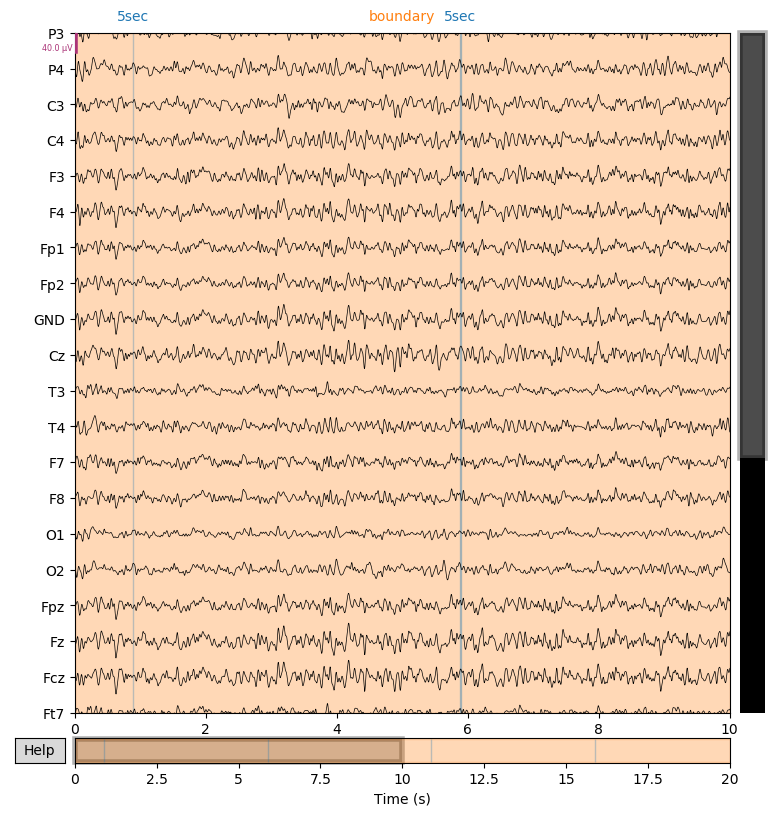

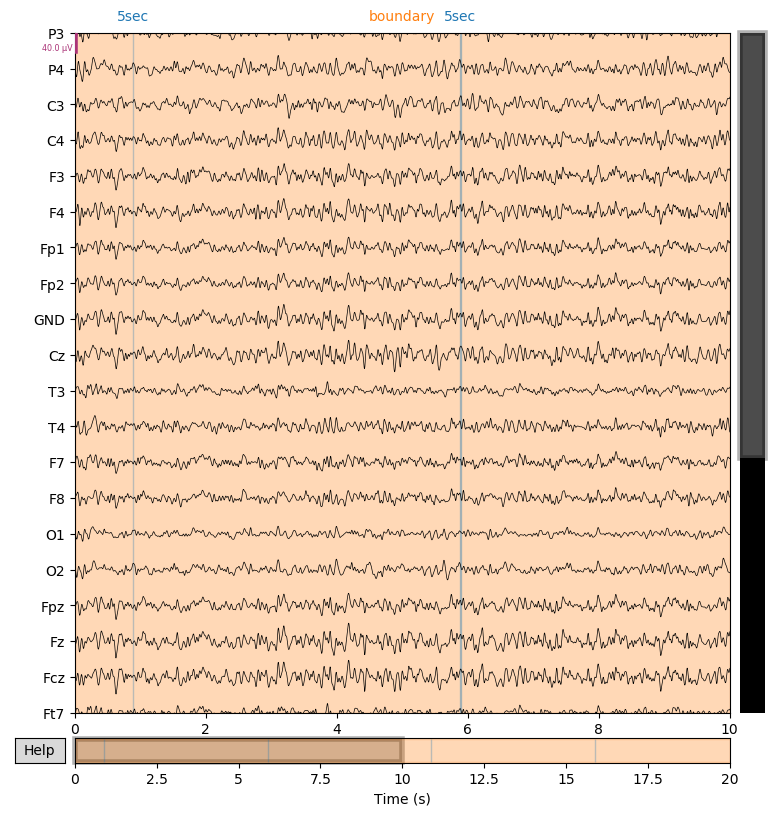

In [2]:
# Replace with the .set file path
path_to_set_file = './Data/T5-1.set'

# Reading the data using MNE
raw2 = mne.io.read_raw_eeglab(path_to_set_file, preload=True)

# Printing basic information about the dataset
print(raw2.info)

# Plotting the raw data
raw2.plot()


## Data Directory Specification and Loading EEG Data

For the processing of ISC data, the data were imported into Python. The script set the directory path where EEG data files are stored, specifically targeting files with the .set extension, using the MNE library which is widely used in neuroscience for EEG data processing. Each subject's data were added to a list using the `read_raw_eeglab` function, ultimately forming a comprehensive dataset. This data is stored in a three-dimensional NumPy array structured as `(subjects, channels, samples)`. The data array is encapsulated within a dictionary. Sample is a parameter that depends on the time of each animation. Table 2 shows the number of samples of each dataset according to the animation time. The position and name of the channels were introduced in the `"channel_names"` and `"positions"` parameters based on the settings of the device by which the data was recorded.


In [3]:
import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning)  # Ignore runtime warnings

fs = 256  # Sampling rate in Hz
data_dir = './data/'  # Actual path to the data files
file_extension = '.set'  # Expected file extension for EEG data files

all_subject_data = []  # Initialize a list to store data from all subjects
channel_names = []  # Initialize a list to store EEG channel names

# Define EEG channel names
channel_names = [
    'P3', 'P4', 'C3', 'C4', 'F3', 'F4', 'Fp1', 'Fp2', 'GND', 'Cz', 'T3', 'T4',
    'F7', 'F8', 'O1', 'O2', 'Fpz', 'Fz', 'Fcz', 'Ft7', 'Ft8', 'Fc3', 'Fc4',
    'Cpz', 'Cp3', 'Cp4', 'T5', 'T6', 'Tp7', 'Tp8', 'Oz', 'Pz'
]

# Positional data (X, Y, Z) for each channel
positions = np.array([
    [-53, -78.8, 55.9], [55.7, -78.6, 56.6], [-65.4, -11.6, 64.4], [67.1, -10.9, 63.6],
    [-50.2, 53.1, 42.2], [51.8, 54.3, 40.8], [-29.4, 83.9, -6.99], [29.9, 84.9, -7.08],
    [0, 0, 0], [0.401, -9.17, 100], [-84.2, -16, -9.35], [85.1, -15, -9.49],
    [-70.3, 42.5, -11.4], [73, 44.4, -12], [-29.4, -112, 8.84], [29.8, -112, 8.8],
    [0.112, 88.2, -1.71], [0.312, 58.5, 66.5], [0.376, 27.4, 88.7], [-80.8, 14.1, -11.1],
    [81.8, 15.4, -11.3], [-60.2, 22.7, 55.5], [62.3, 23.7, 55.6], [0.386, -47.3, 99.4],
    [-63.6, -47, 65.6], [66.6, -46.6, 65.6], [-72.4, -73.5, -2.49], [73.1, -73.1, -2.54],
    [-84.8, -46, -7.06], [85.5, -45.5, -7.13], [0.108, -115, 14.7], [0.325, -81.1, 82.6]
])

# Generate a list of file paths for EEG data
set_files = [os.path.join(data_dir, file) for file in os.listdir(data_dir) if file.endswith(file_extension)]

# Using MNE library to read EEG data and append the data to the all_subject_data list
for set_file in set_files:
    raw = mne.io.read_raw_eeglab(set_file, preload=True)
    all_subject_data.append(raw.get_data())
    channel_names = raw.ch_names  # Update channel names from the read data

# Convert the list of EEG data arrays into a single numpy array (subjects, channels, samples)
all_data_np = np.array(all_subject_data)

# Data structured for canonical correlation analysis (CCA)
data_for_cca = {
    'watching_animation': {
        'data': all_data_np,
        'channel_names': channel_names
    }
}

output_path = []
# Create a directory based on the name of the first file read
if set_files:
    first_file_name = os.path.basename(set_files[0])
    folder_name = first_file_name.split('.')[0]  # Use the name part as folder name, assuming the file name has an extension
    output_path = os.path.join(data_dir, folder_name)
    if not os.path.exists(output_path):
        os.makedirs(output_path)
    print(f"Directory created at: {output_path}")
else:
    print("No .set files found in the directory.")

print("Output path is", output_path)

Reading d:\Article2\ICA\Inter-Subject_Correlation-master\data\T5-1.fdt
Reading 0 ... 5120  =      0.000 ...    20.000 secs...
Reading d:\Article2\ICA\Inter-Subject_Correlation-master\data\T5-15.fdt
Reading 0 ... 5120  =      0.000 ...    20.000 secs...
Reading d:\Article2\ICA\Inter-Subject_Correlation-master\data\T5-11.fdt
Reading 0 ... 5120  =      0.000 ...    20.000 secs...
Reading d:\Article2\ICA\Inter-Subject_Correlation-master\data\T5-12.fdt
Reading 0 ... 5120  =      0.000 ...    20.000 secs...
Reading d:\Article2\ICA\Inter-Subject_Correlation-master\data\T5-13.fdt
Reading 0 ... 5120  =      0.000 ...    20.000 secs...
Reading d:\Article2\ICA\Inter-Subject_Correlation-master\data\T5-14.fdt
Reading 0 ... 5120  =      0.000 ...    20.000 secs...
Reading d:\Article2\ICA\Inter-Subject_Correlation-master\data\T5-15.fdt
Reading 0 ... 5120  =      0.000 ...    20.000 secs...
Reading d:\Article2\ICA\Inter-Subject_Correlation-master\data\T5-2.fdt
Reading 0 ... 5120  =      0.000 ...    2

## Execution of Canonical Correlation Analysis

CCA aims to identify spatial filters (\(w\)) enhancing correlation between brain signals under different conditions. It optimizes correlation between linear projections (\(y_1\) and \(y_2\)) from two EEG datasets (\(X_1\) and \(X_2\)).

**Covariance Matrix Calculation**

Covariance matrices quantify channel correlation. \(R_w\) assesses correlation within conditions, \(R_b\) across conditions.

**Extraction of Eigenvectors and Eigenvalues**

Adjusted covariance matrices yield eigenvectors as spatial filters. Larger eigenvalues indicate more significant features.

In `train_cca`, data from 15 individuals across 32 channels is prepared, restructuring the original array format (\(subjects, channels, samples\)) for independent analyses.

- The spatial filter matrix (\(W\)), a 32 × 32 matrix, contains columns representing spatial filters.
- A vector of eigenvalues ranks eigenvectors, larger values indicating stronger correlations.

By integrating these steps, `train_cca` effectively applies CCA to uncover relationships between multivariate datasets, optimizing spatial filter identification and enhancing signal correlation under various conditions.

### "Run Correlated Component Analysis on your training data.
Parameters:
data : dict
    Dictionary with keys are names of conditions and values are numpy
    arrays structured like (subjects, channels, samples).
    The number of channels must be the same between all conditions!

Returns:
W : np.array
    Columns are spatial filters. They are sorted in descending order, it means that first column-vector maximize
    correlation the most.
ISC : np.array
    Inter-subject correlation sorted in descending order



In [4]:
def train_cca(data):


    start = default_timer()
    C = len(data.keys())
    print(f'train_cca - calculations started. There are {C} conditions')
    gamma = 0.1
    Rw, Rb = 0, 0
    
    for cond in data.values():
        N, D, T = cond['data'].shape
        cond = cond['data'].reshape(D * N, T)
        
        # Compute covariance matrices
        Rij = np.swapaxes(np.reshape(np.cov(cond), (N, D, N, D)), 1, 2)
        Rw += np.mean([Rij[i, i, :, :] for i in range(N)], axis=0)
        Rb += np.mean([Rij[i, j, :, :] for i in range(N) for j in range(N) if i != j], axis=0)

    Rw /= C
    Rb /= C
    Rw_reg = (1 - gamma) * Rw + gamma * np.mean(eigh(Rw)[0]) * np.identity(Rw.shape[0])
    
    ISC, W = eigh(Rb, Rw_reg)
    ISC, W = ISC[::-1], W[:, ::-1]  # Sort in descending order

    stop = default_timer()
    print(f'Elapsed time: {round(stop - start)} seconds.')
    return W, ISC


        #reshaped_data = cond['data'].reshape(D * N, T)
        
        # Compute covariance matrices
        #Rij = np.swapaxes(np.reshape(np.cov(reshaped_data), (N, D, N, D)), 1, 2)

## Application of Spatial Filters

### Function Description:

This function, `apply_cca`, computes various metrics related to Inter-subject Correlation (ISC) and scalp projections using precomputed spatial filters.

### Parameters:
- `X_dict`: A dictionary containing EEG data in a 3-D numpy array format with keys 'data' for EEG data and 'channel_names' for channel names.
- `W`: A numpy array representing spatial filters.
- `fs`: An integer representing the frequency sampling.

### Returns:
- `ISC`: A numpy array of inter-subject correlation values, sorted in descending order.
- `ISC_persecond`: Inter-subject correlation values per second.
- `ISC_bysubject`: Inter-subject correlation values organized by subject.
- `A`: Scalp projections of ISC.

### Process:
The function first reshapes the input EEG data and computes covariance matrices for within and between subjects. It then calculates ISC, scalp projections, ISC by subject, and ISC per second. Finally, it returns the computed values.



### Applying precomputed spatial filters to your data.

Parameters:
X : ndarray
    3-D numpy array structured like (subject, channel, sample)
W : ndarray
    Spatial filters.
fs : int
    Frequency sampling.
Returns:
ISC : ndarray
    Inter-subject correlations values are sorted in descending order.
ISC_persecond : ndarray
    Inter-subject correlations values per second where first row is the most correlated.
ISC_bysubject : ndarray
    Description goes here.
A : ndarray
    Scalp projections of ISC.


In [5]:

def apply_cca(X_dict, W, fs):

    start = default_timer()
    print('apply_cca - calculations started')

    X = X_dict['data']
    channel_names = X_dict['channel_names']
    N, D, T = X.shape
    X = X.reshape(D * N, T)

    # Rij
    Rij = np.swapaxes(np.reshape(np.cov(X), (N, D, N, D)), 1, 2)

    # Rw
    Rw = np.mean([Rij[i, i, :, :] for i in range(0, N)], axis=0)
    # Rb
    Rb = np.mean([Rij[i, j, :, :] for i in range(0, N) for j in range(0, N) if i != j], axis=0)

    # ISCs
    ISC = np.sort(np.diag(np.transpose(W) @ Rb @ W) / np.diag(np.transpose(W) @ Rw @ W))[::-1]

    # Scalp projections
    A = np.linalg.solve(Rw @ W, np.transpose(W) @ Rw @ W)

    # ISC by subject
    print('by subject is calculating')
    ISC_bysubject = np.empty((D, N))
    for subj_k in range(0, N):
        ISC_bysubject[:, subj_k] = np.diag(np.transpose(W) @ Rb @ W) / np.diag(np.transpose(W) @ Rw @ W)

    # ISC per second
    print('by persecond is calculating')
    ISC_persecond = np.empty((D, int(T / fs) + 1))
    for t in range(0, T, fs):
        Xt = X[:, t:t+fs]
        Rij = np.cov(Xt)
        Rw = np.mean([Rij[i:i + D, i:i + D] for i in range(0, D * N, D)], axis=0)
        Rb = np.mean([Rij[i:i + D, j:j + D] for i in range(0, D * N, D) for j in range(0, D * N, D) if i != j], axis=0)
        ISC_persecond[:, t // fs] = np.diag(np.transpose(W) @ Rb @ W) / np.diag(np.transpose(W) @ Rw @ W)

    stop = default_timer()
    print(f'Elapsed time: {round(stop - start)} seconds.')
    return ISC, ISC_persecond, ISC_bysubject, A

In [6]:
# Assume that `W` and `ISC` are calculated by the `train_cca` function
W, ISC = train_cca(data_for_cca)

# Applying spatial filters W to EEG data to obtain ISC
ISC_results, ISC_persecond, ISC_bysubject, A = apply_cca(data_for_cca['watching_animation'], W, fs)


train_cca - calculations started. There are 1 conditions
Elapsed time: 0 seconds.
apply_cca - calculations started
by subject is calculating
by persecond is calculating
Elapsed time: 0 seconds.


## Data Augmentation Techniques

To validate findings, data augmentation techniques like shuffling and phase randomization are applied. These methods establish baselines against which the real data's statistical significances are evaluated. Shuffling breaks temporal dependencies, and phase randomization alters the Fourier transform's phase components, maintaining the power spectrum but randomizing temporal structures.

### `shuffle_in_time` Function:
Splits time series data into fixed-length windows and shuffles the order of these windows.
- **Parameters:**
  - `data`:  Dictionary with keys are names of conditions and values are numpy arrays structured like (subjects, channels, samples)..
  - `window`: The length of one split.
  - `fs`: Frequency sampling.
- **Returns:**
  - `data_shuffled`: Shuffled data with the same structure as `data`.

### `phase_randomized` Function:
Performs phase randomization on EEG data.
- **Parameters:**
  - `X`: EEG data with dimensions (subjects, channels, samples).
- **Returns:**
  - `Xr`: Phase-randomized EEG data.

In [7]:
def shuffle_in_time(data, window, fs):

    data_shuffled = dict()

    for cond, values in data.items():
        cond_shuffled = np.zeros(values.shape)
        n_samples = values[0].shape[1]
        n_splits = n_samples/fs/window

        for subj_i, subj in enumerate(values):
            for ch_i, ch in enumerate(subj):
                splitted = np.array_split(ch, n_splits)
                np.random.shuffle(splitted)
                ch_shuffled = np.concatenate(splitted)
                cond_shuffled[subj_i, ch_i, :] = ch_shuffled

        data_shuffled[str(cond)] = cond_shuffled

    return data_shuffled




def phase_randomized(X):
    start = default_timer()

    N, D, T = X.shape
    print(f'\n{N} subjects, {D} sensors and {T} samples')

    Xr = np.empty((N, D, T))

    for subject in range(0, N):

        Xfft = np.fft.rfft(X[subject, :, :], T)
        ampl = np.abs(Xfft)
        phi = np.angle(Xfft)
        # np.random.seed(42)
        phi_r = 4 * np.arccos(0) * np.random.rand(1, int(T / 2 - 1)) - 2 * np.arccos(0)
        Xfft[:, 1:int(T / 2)] = ampl[:, 1:int(T / 2)] * np.exp(
            np.sqrt(-1 + 0j) * (phi[:, 1:int(T / 2)] + npm.repmat(phi_r, D, 1)))
        Xr[subject, :, :] = np.fft.irfft(Xfft, T)

    stop = default_timer()
    print(f'Elapsed time: {round(stop - start)} seconds.')

    return Xr

### Function Description: `plot_isc`

Defines a function to plot Inter-Subject Correlation (ISC) analysis results.

- **Parameters:**
  - `isc_all`: Dictionary containing ISC analysis results.
  - `output_path`: Path to save the plots.

- **Process:**
  - Iterates over each condition in `isc_all`.
  - Creates bar charts for ISC and ISC per second for the top three components.
  - Generates boxplots for ISC by subject for each condition.



In [8]:
# Get channel names from the raw data object
channel_names = raw2.ch_names
# Print channel names after transposing them for better visibility
print(np.transpose(channel_names))

# Define a function to plot Inter-Subject Correlation (ISC) analysis results
def plot_isc(isc_all, output_path):
    # Define a variable 'conditions' at the beginning of the function to store keys from isc_all
    conditions = list(isc_all.keys())  

    # Iterate over each condition to create plots
    for condition in conditions:
        data = isc_all[condition]
        num_components = len(data['ISC'])
        barWidth = 0.2  # Width of the bars in the bar chart
        
        # Plotting the bar chart for each component
        plt.figure(figsize=(10, 5))
        for comp_idx in range(min(3, num_components)):
            plt.bar(comp_idx, data['ISC'][comp_idx], width=barWidth,
                    label=f'{data["sorted_channel_names"][comp_idx]} (Comp {comp_idx+1})')
        plt.xlabel('Components')
        plt.ylabel('ISC')
        plt.title(f'ISC for {condition}')
        plt.xticks(range(min(3, num_components)), [f'Comp {i+1}' for i in range(min(3, num_components))])
        plt.legend()
        plt.show()
        plt.savefig(os.path.join(output_path, f'ISC_Bar_Chart_{condition}.png'))
        plt.close()

        # Plot ISC per second for each component
        plt.figure(figsize=(12, 8))
        for comp_idx in range(min(3, num_components)):
            plt.subplot(min(3, num_components), 1, comp_idx+1)
            plt.plot(data['ISC_persecond'][comp_idx], label=f'Component {comp_idx+1} ({data["sorted_channel_names"][comp_idx]})')
            plt.xlabel('Time (s)')
            plt.ylabel('ISC')
            plt.title(f'ISC per second for {condition} - Component {comp_idx+1}')
            plt.legend()
        plt.tight_layout()
        plt.show()
        plt.savefig(os.path.join(output_path, f'ISC_Per_Second_{condition}.png'))
        plt.close()

    # Create a plot for ISC by subject for each condition using boxplots
    fig, ax = plt.subplots()
    isc_bysubject_data = [data['ISC_bysubject'][0, :] for data in isc_all.values()]
    ax.boxplot(isc_bysubject_data)
    ax.set_ylabel('ISC')
    ax.set_ylim([0.078, 0.086])
    ax.set_xlabel('Conditions', fontweight='bold')
    ax.set_title('ISC by subject for each condition')
    plt.savefig(os.path.join(output_path, 'ISC_By_Subject.png'))
    plt.close()


['P3' 'P4' 'C3' 'C4' 'F3' 'F4' 'Fp1' 'Fp2' 'GND' 'Cz' 'T3' 'T4' 'F7' 'F8'
 'O1' 'O2' 'Fpz' 'Fz' 'Fcz' 'Ft7' 'Ft8' 'Fc3' 'Fc4' 'Cpz' 'Cp3' 'Cp4' 'T5'
 'T6' 'Tp7' 'Tp8' 'Oz' 'Pz']


### Sorting Channels:

Sorts channels based on the highest absolute weight in each spatial filter.

### Shuffling Data:

Shuffles data with a 10-second time window.

- **Parameters:**
  - `data_for_cca['watching_animation']['data']`: EEG data for the 'watching_animation' condition.
  - `window`: Length of each split.
  - `fs`: Frequency sampling.

### Applying Random Phase:

Applies random phase to the EEG data.

### Example: Calculate ISC for Shuffled Data:

Calculates Inter-Subject Correlation (ISC) for shuffled data.

### Example: Calculate ISC for Data with Randomized Phase:

Calculates ISC for data with randomized phase.


In [9]:
# Sort channels based on the highest absolute weight in each spatial filter
sorted_indices = np.argsort(np.abs(W), axis=0)[::-1]  # Largest weights in each column
sorted_channel_names = [channel_names[idx] for idx in sorted_indices[:, 0]]  # Only for the first filter

# Shuffle data with a 10-second time window
# Ensure proper data array is passed to the function
shuffled_data = shuffle_in_time({'watching_animation': data_for_cca['watching_animation']['data']}, window=10, fs=256)

# Apply random phase
randomized_phase_data = phase_randomized(data_for_cca['watching_animation']['data'])

# Example: Calculate ISC for shuffled data
shuffled_ISC_results, shuffled_ISC_persecond, shuffled_ISC_bysubject, shuffled_A = apply_cca({'data': shuffled_data['watching_animation'], 'channel_names': channel_names}, W, fs)

# Example: Calculate ISC for data with randomized phase
randomized_ISC_results, randomized_ISC_persecond, randomized_ISC_bysubject, randomized_A = apply_cca({'data': randomized_phase_data, 'channel_names': channel_names}, W, fs)



15 subjects, 32 sensors and 5121 samples
Elapsed time: 0 seconds.
apply_cca - calculations started
by subject is calculating
by persecond is calculating
Elapsed time: 0 seconds.
apply_cca - calculations started
by subject is calculating
by persecond is calculating
Elapsed time: 0 seconds.


### ISC Analysis Results Dictionary:

Creates dictionaries to store ISC analysis results for different conditions, including shuffled and randomized data.

### Function: `save_dicts_to_excel`

Saves dictionaries containing ISC analysis results to Excel files.

- **Parameters:**
  - `dicts`: Dictionary containing ISC analysis results for different conditions.
  - `output_path`: Path to save the Excel files.

- **Process:**
  - Ensures the existence of the output path.
  - Saves each dictionary in a separate Excel file.


In [10]:
isc_all = {
    'condition1': {
        'ISC': ISC_results,            # ISC results from apply_cca
        'ISC_persecond': ISC_persecond,  # ISC per second results from apply_cca
        'ISC_bysubject': ISC_bysubject,  # ISC by subject results from apply_cca
        'sorted_channel_names': sorted_channel_names  # List of channel names sorted by their weights in components
    },
    # Add other conditions if needed
}

# Create isc_all dictionary to display shuffled and randomized data
isc_all_shuffled = {
    'shuffled': {
        'ISC': shuffled_ISC_results,
        'ISC_persecond': shuffled_ISC_persecond,
        'ISC_bysubject': shuffled_ISC_bysubject,
        'sorted_channel_names': sorted_channel_names
    }
}

isc_all_randomized = {
    'randomized': {
        'ISC': randomized_ISC_results,
        'ISC_persecond': randomized_ISC_persecond,
        'ISC_bysubject': randomized_ISC_bysubject,
        'sorted_channel_names': sorted_channel_names
    }
}

def save_dicts_to_excel(dicts, output_path):
    # Ensure the existence of the output path
    os.makedirs(output_path, exist_ok=True)
    
    # Save each dictionary in a separate Excel file
    for name, data_dict in dicts.items():
        file_path = os.path.join(output_path, f'{name}.xlsx')
        with pd.ExcelWriter(file_path, engine='openpyxl') as writer:
            for key, data in data_dict.items():
                if 'sorted_channel_names' in data:
                    df = pd.DataFrame(data)
                    if key == 'sorted_channel_names':
                        continue
                    df.index = data['sorted_channel_names']
                else:
                    df = pd.DataFrame(data)
                df.to_excel(writer, sheet_name=key)

# Store the data in a dictionary
dicts = {
    'condition1': isc_all['condition1'],
    'shuffled': isc_all_shuffled['shuffled'],
    'randomized': isc_all_randomized['randomized']
}


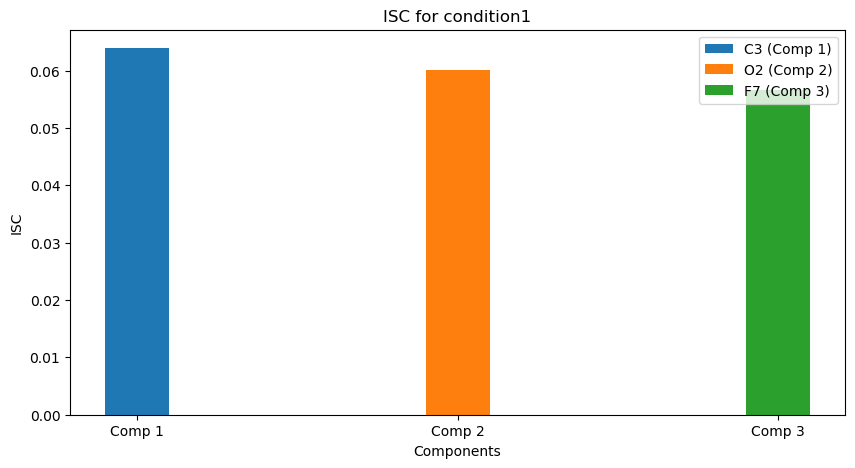

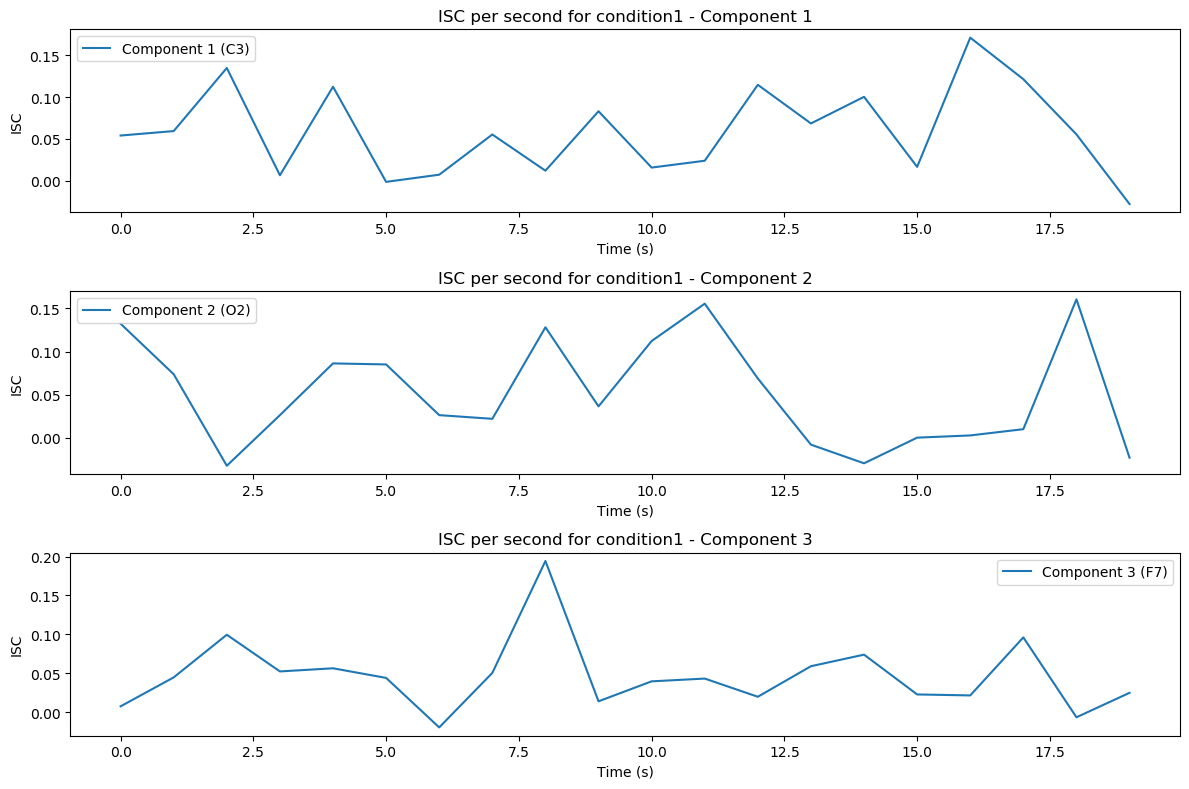

condition1


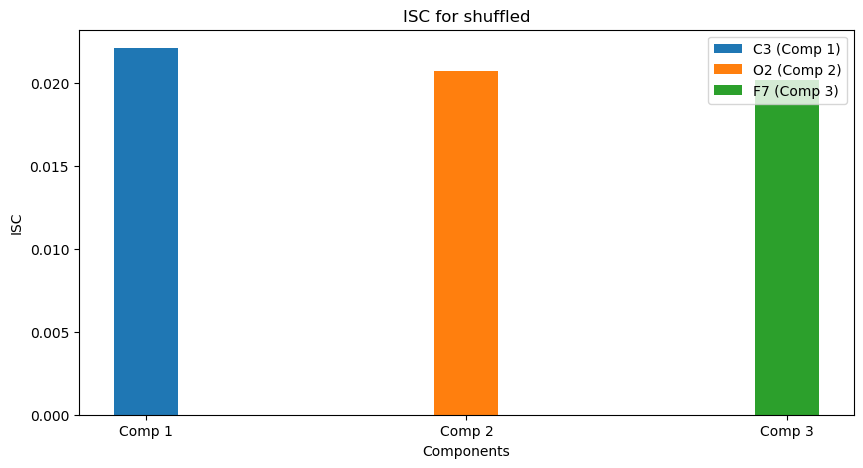

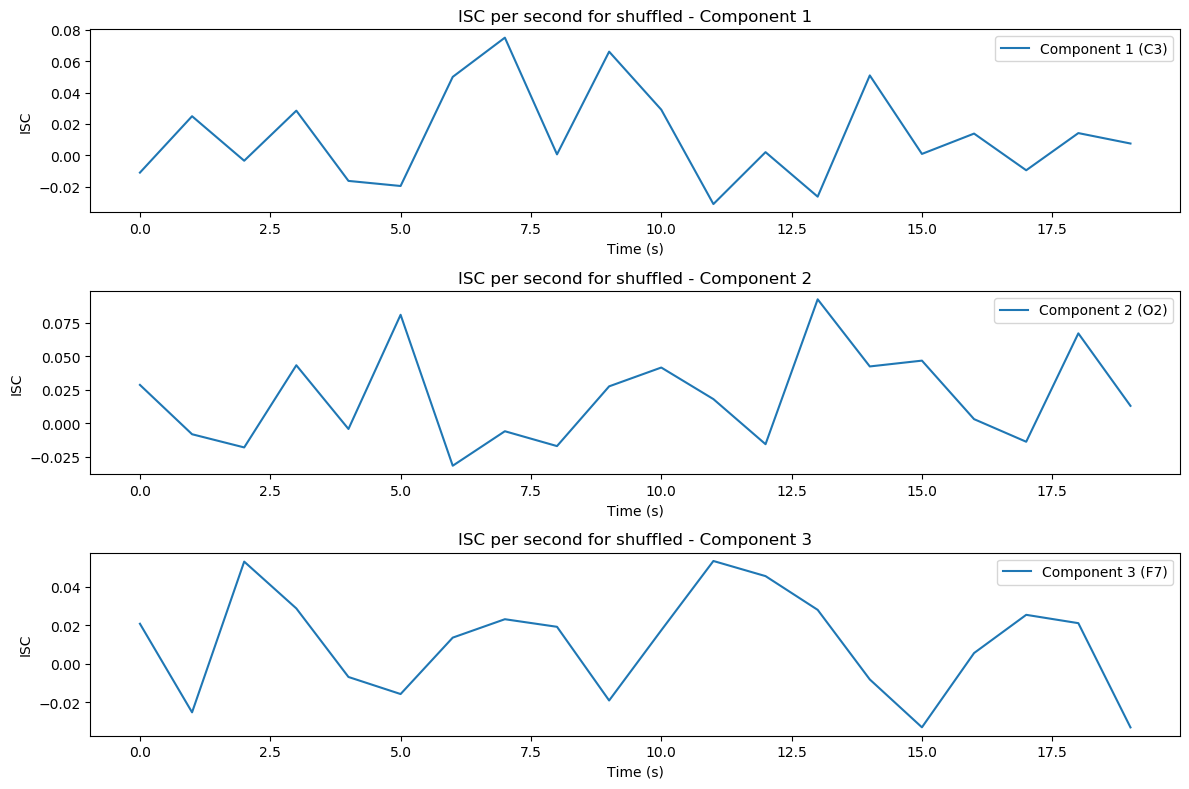

shuffled


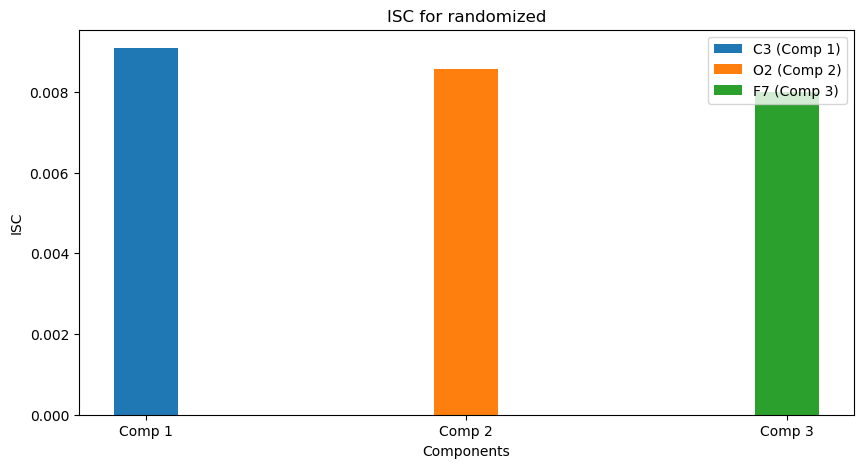

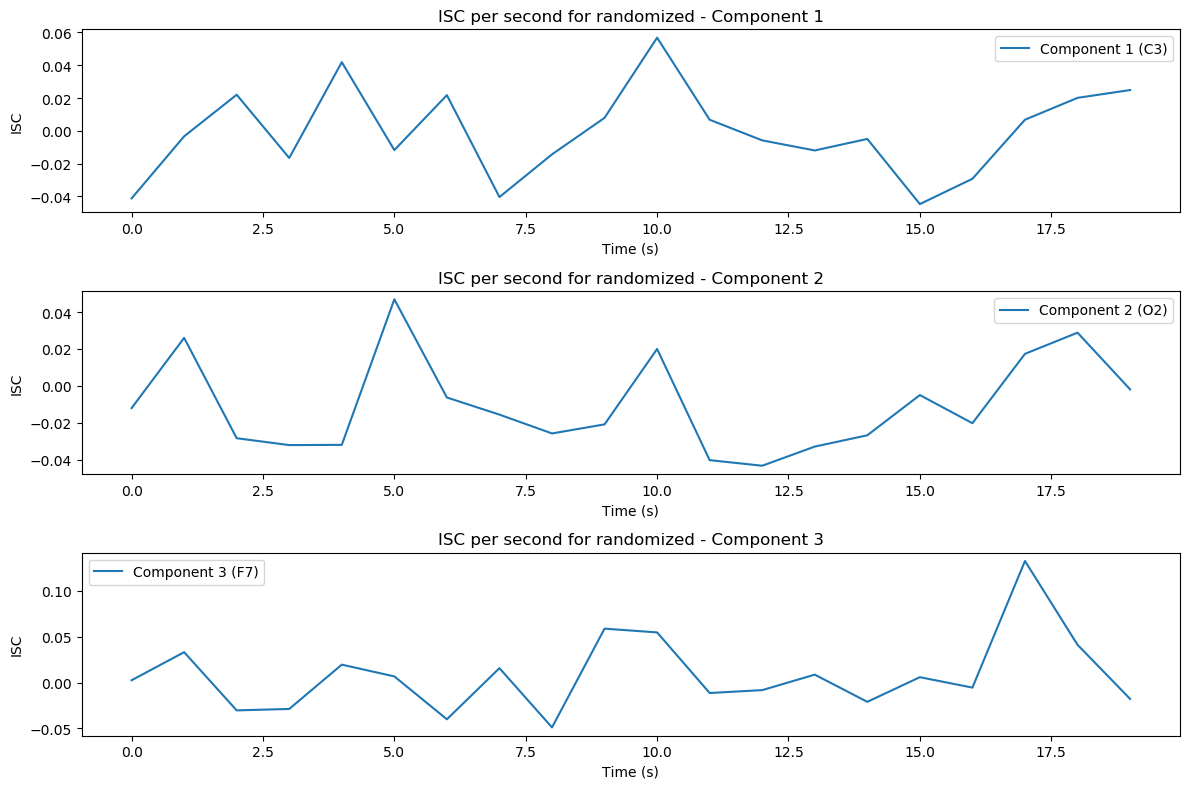

randomized


c:\Users\ASUS\.conda\envs\env1\lib\site-packages\ipykernel_launcher.py:39: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


In [11]:
plot_isc(isc_all, output_path)
print ('condition1')
plot_isc(isc_all_shuffled, output_path)
print ('shuffled')
plot_isc(isc_all_randomized, output_path)
print ('randomized')
save_dicts_to_excel(dicts, output_path)

## EEG Data Processing and Topographic Visualization

### Data Preparation:

The code begins by organizing EEG data, including sorted channel names and ISC per second, into a structured array. It then constructs a montage and an Info object using MNE-Python, essential for spatial visualization.

### Topographic Plot Generation:

The subsequent section iterates over each data column to create topographic maps, representing the spatial distribution of correlations across EEG channels. Each map is meticulously plotted and saved individually, allowing for detailed analysis of channel interactions.

### Combined Topographic Plot:

Finally, a combined topographic plot is generated, consolidating the individual maps into a comprehensive visualization. This plot offers a holistic view of channel correlations and is saved for further examination.

---

*Note: Ensure the proper setup of MNE-Python for executing the code.*


First few rows of data:
[['P3' '-0.0024952062818810235' '0.030881394602921962'
  '-0.019116524530251706' '-0.023108083392362973' '0.04861990654824451'
  '0.032137142660696554' '-0.007928776251678218' '-0.012561497143994453'
  '-0.008406248493699265' '0.004811244239868476' '-0.0124016067055587'
  '0.02059180610229164' '0.0008785898096008335' '-0.015122595686943146'
  '-0.033682656044499104' '-0.020853448958771052'
  '-0.0019950553647125097' '0.02247652911111671' '-0.020388756942593893'
  '0.02968849037434889' 'nan']
 ['P4' '0.06642891170360993' '-0.00068042060501528'
  '-0.013315198279996446' '-0.02024357087202552' '0.03766595465901105'
  '-0.02581239798166867' '-0.0014895811437464375' '0.07885540008905695'
  '-0.020497150621683394' '0.021481340482589966' '0.04450344599435038'
  '0.09326319692167248' '-0.028629876999368743' '0.06517918343494221'
  '0.08995938375510688' '0.12269171312824396' '0.11119861302101623'
  '0.012678022027811089' '0.017154803687663478' '0.06840645210163455'
  'na

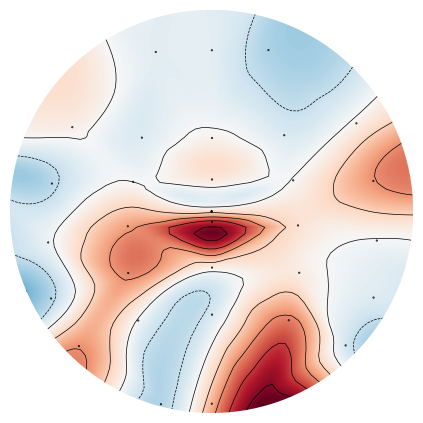

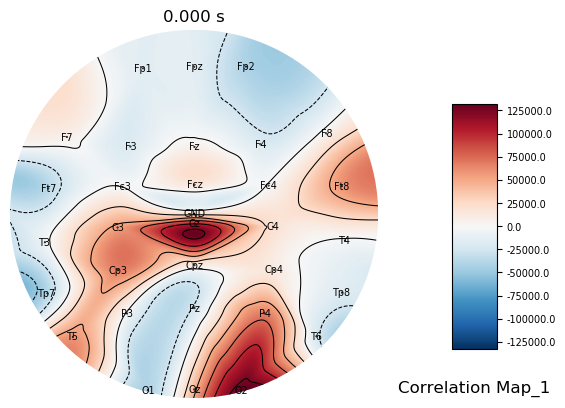

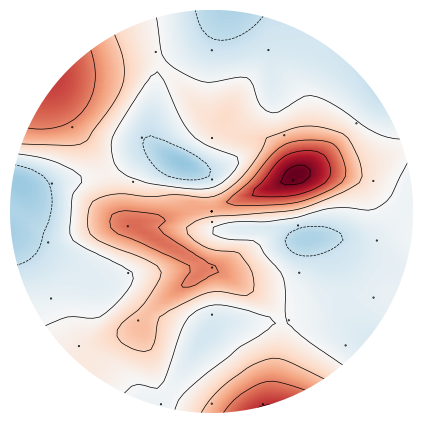

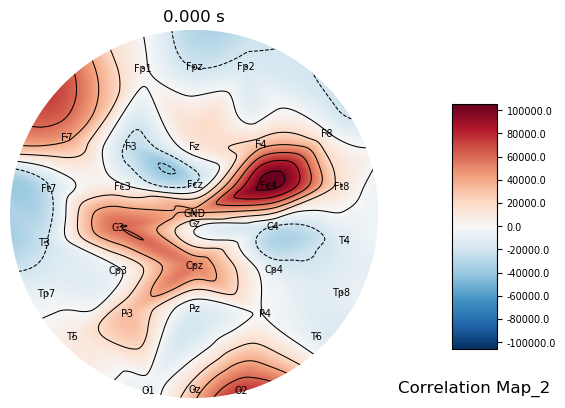

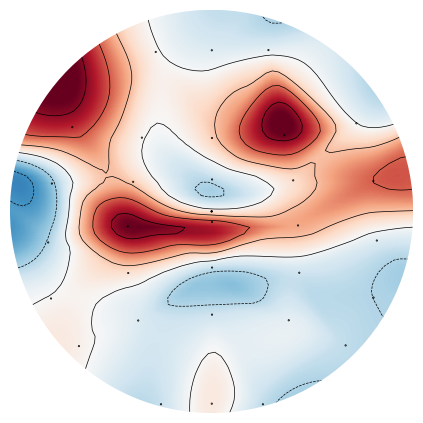

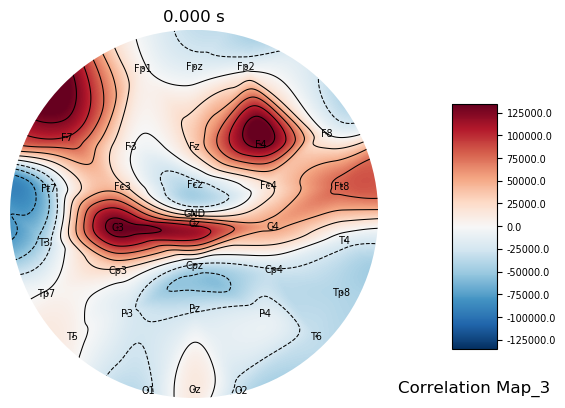

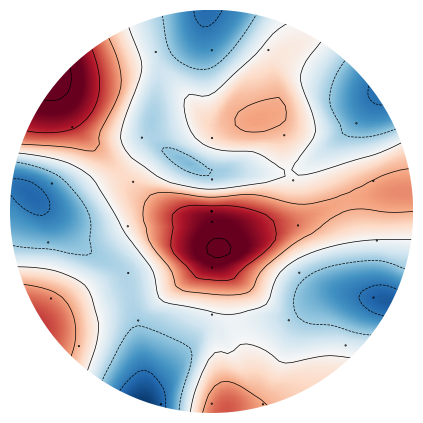

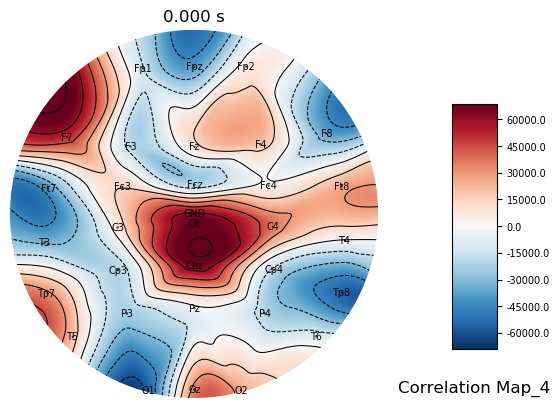

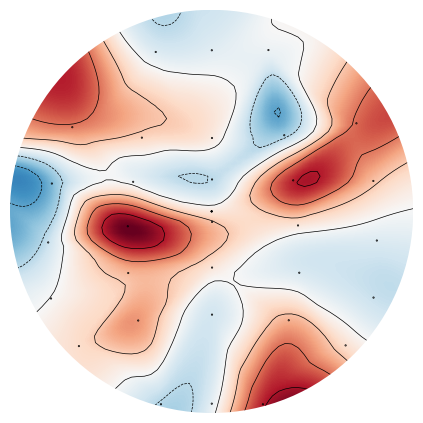

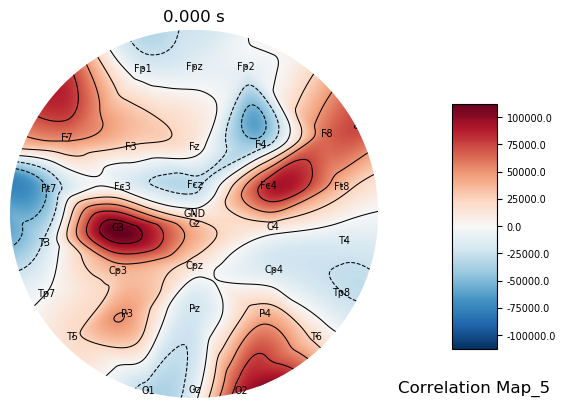

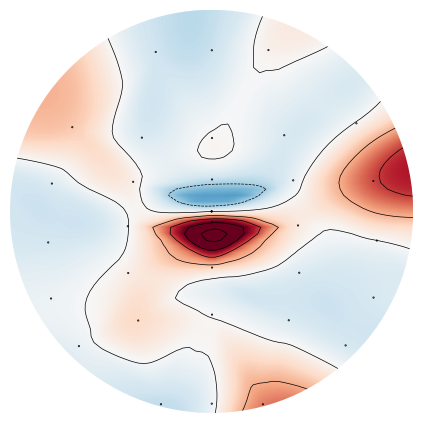

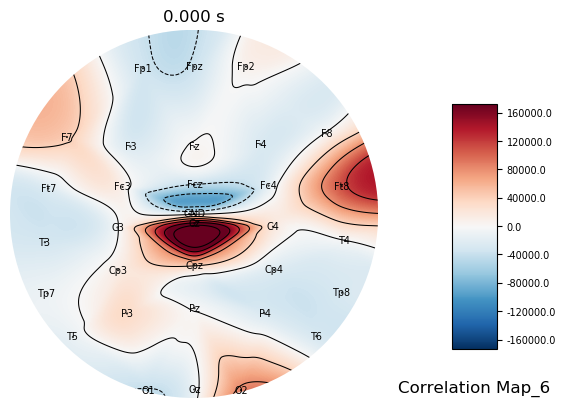

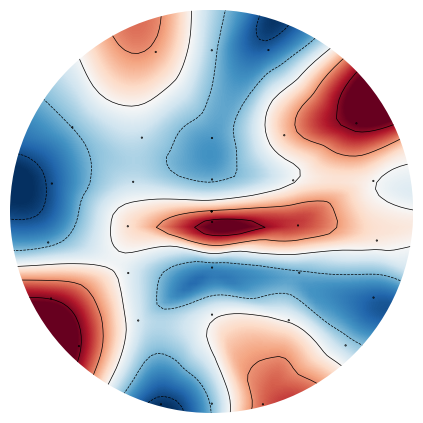

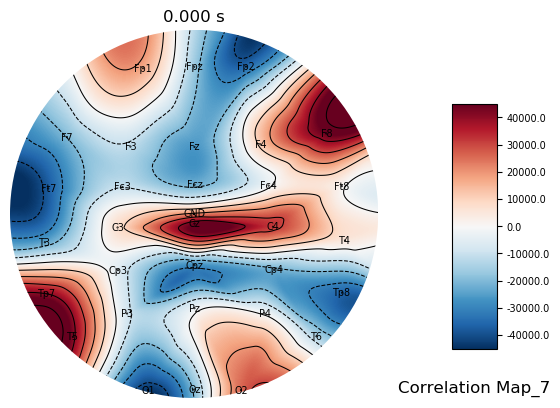

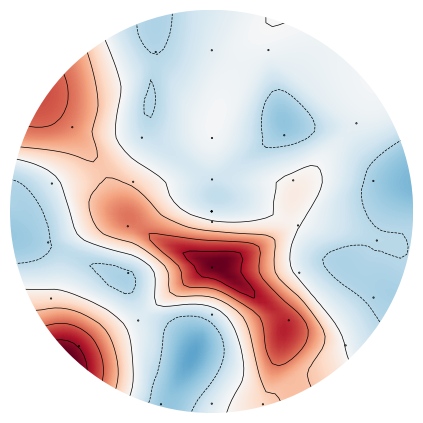

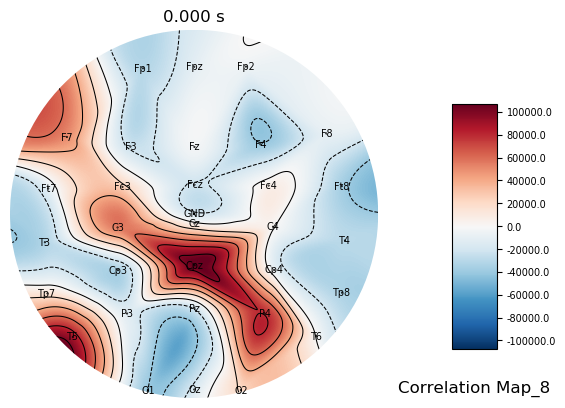

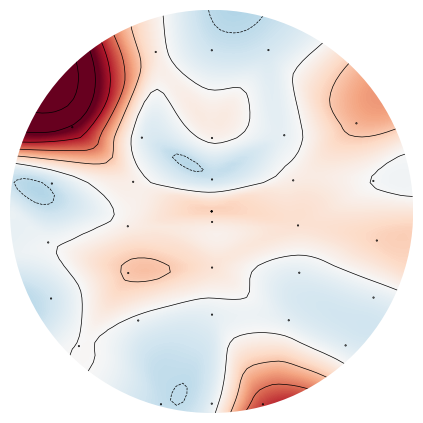

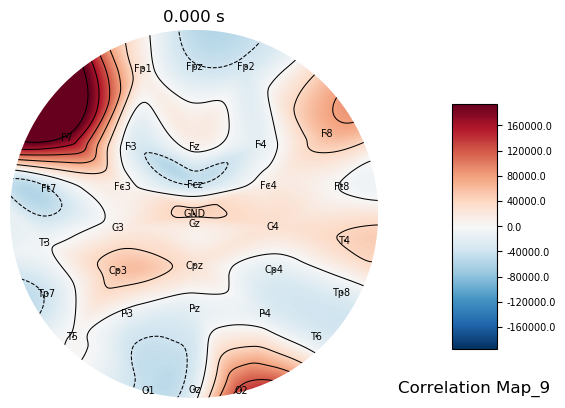

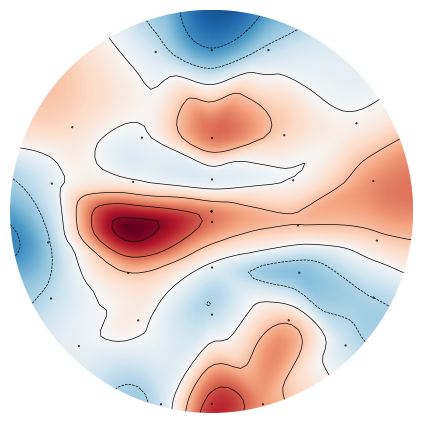

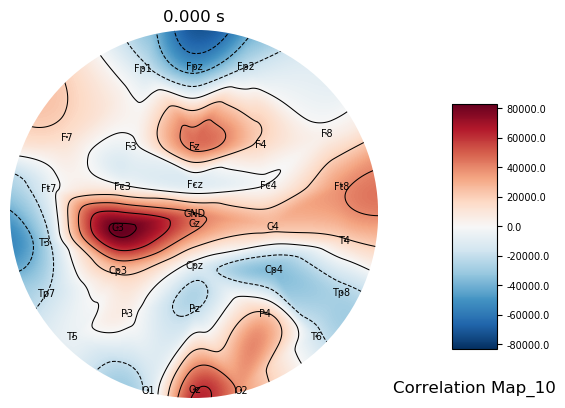

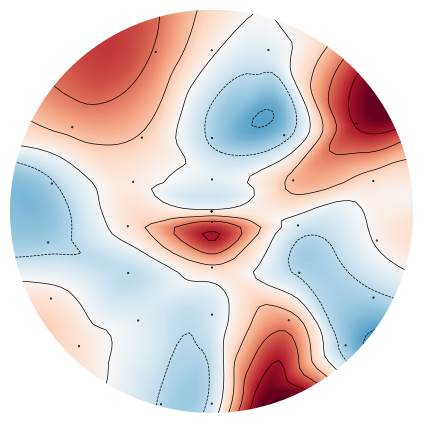

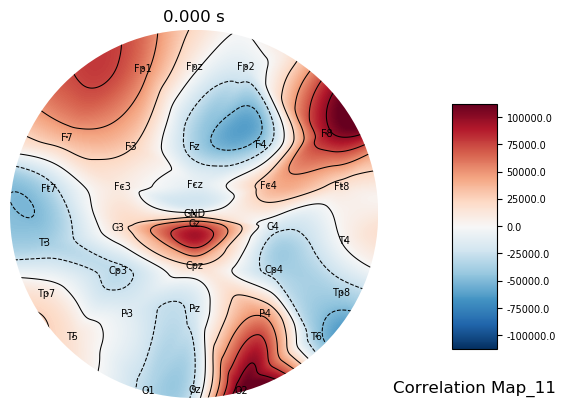

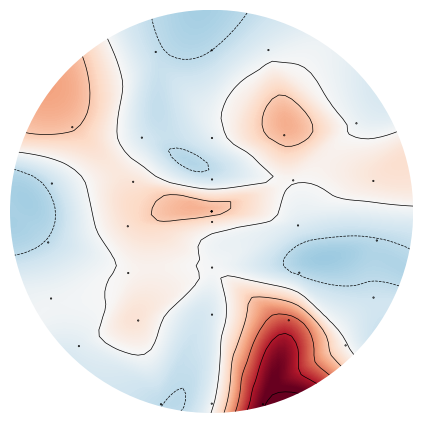

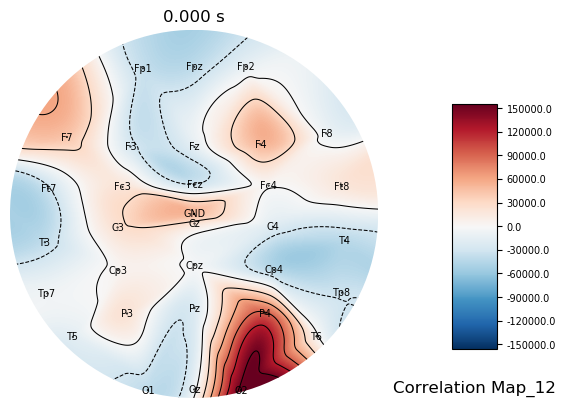

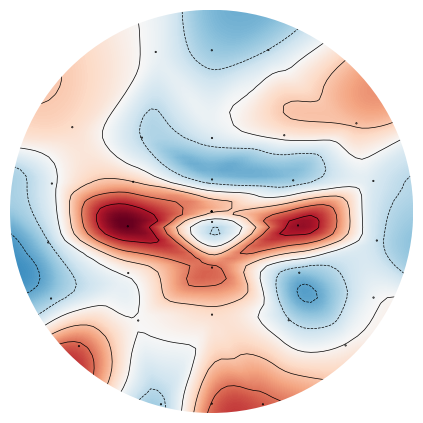

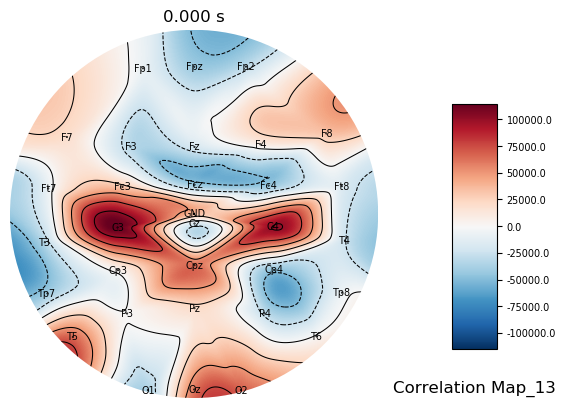

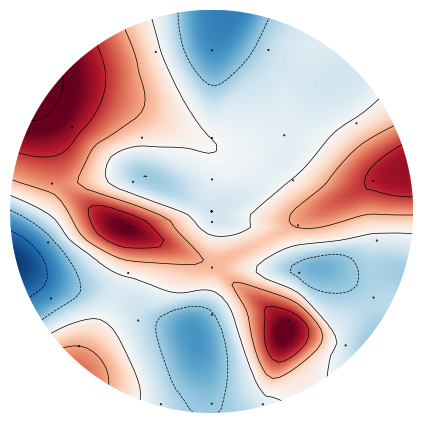

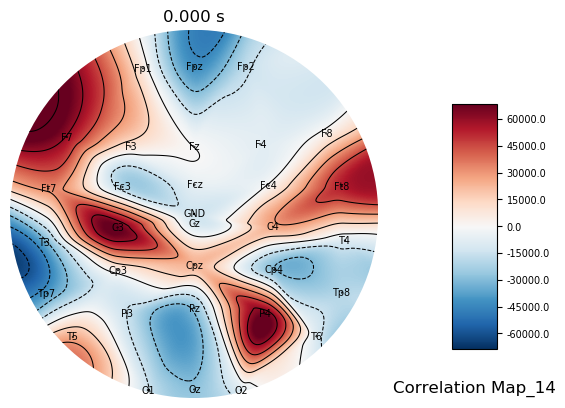

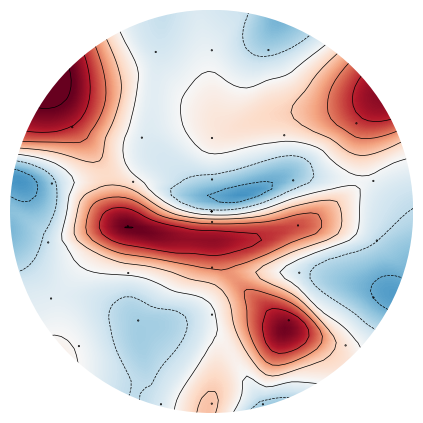

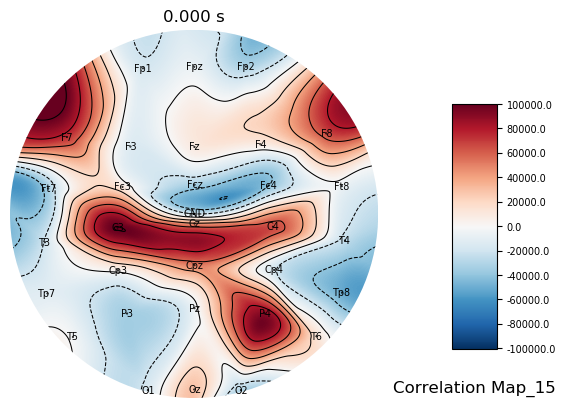

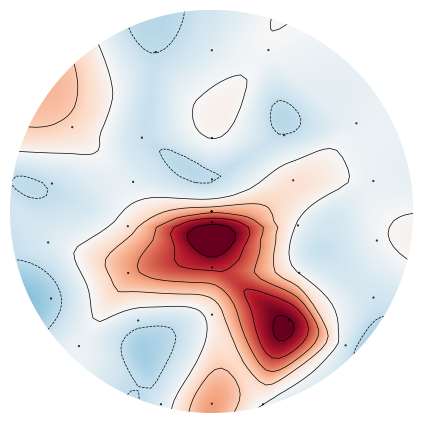

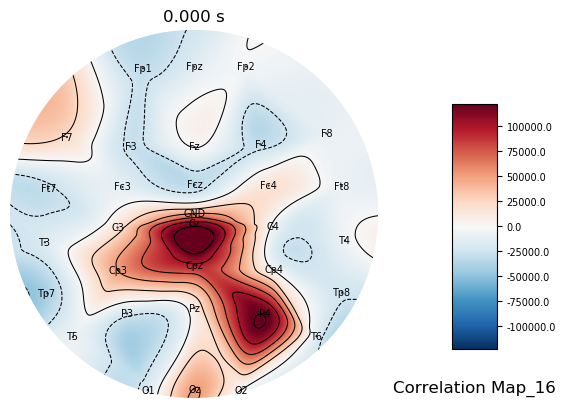

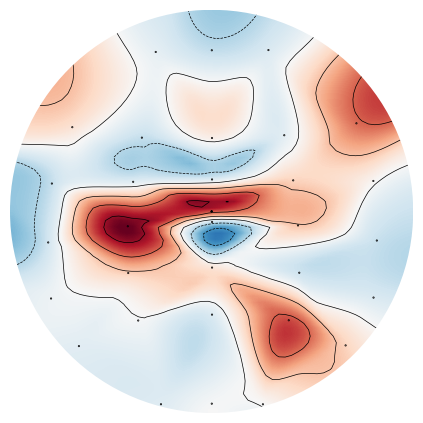

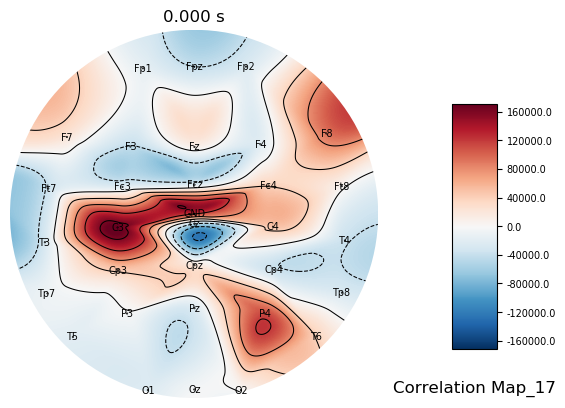

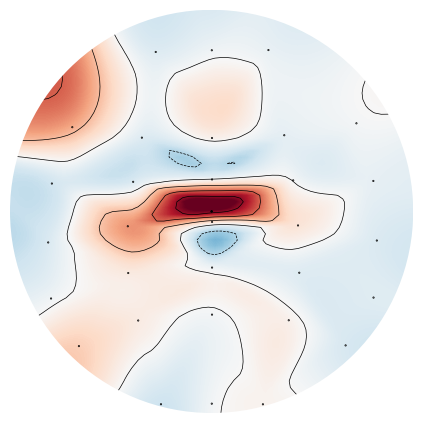

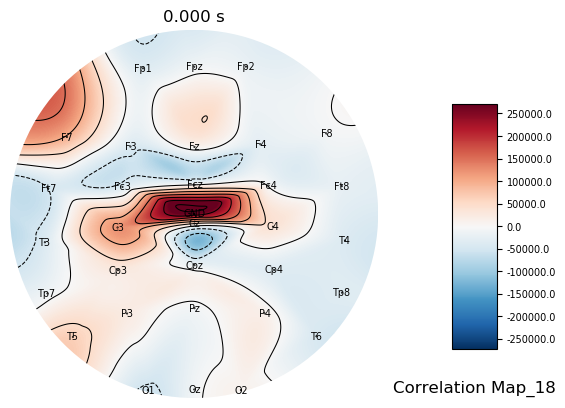

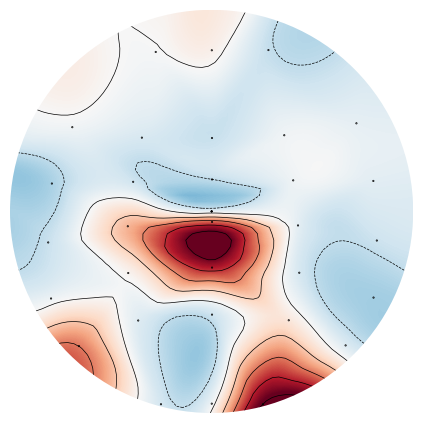

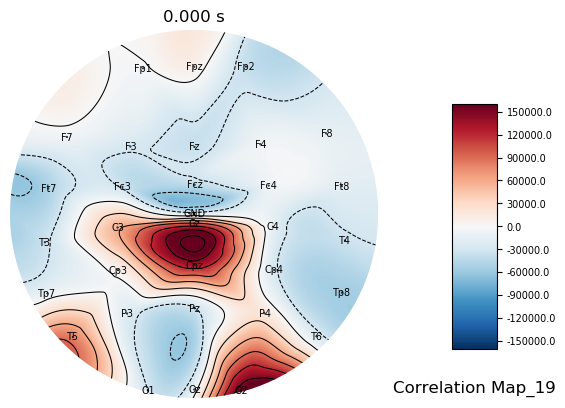

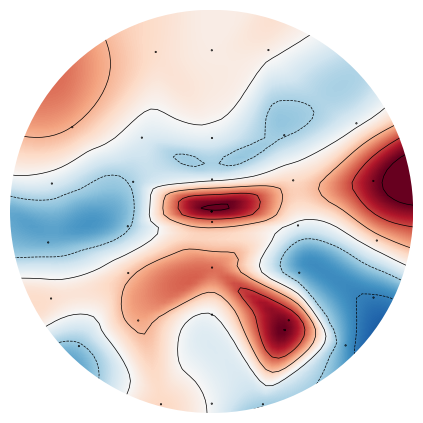

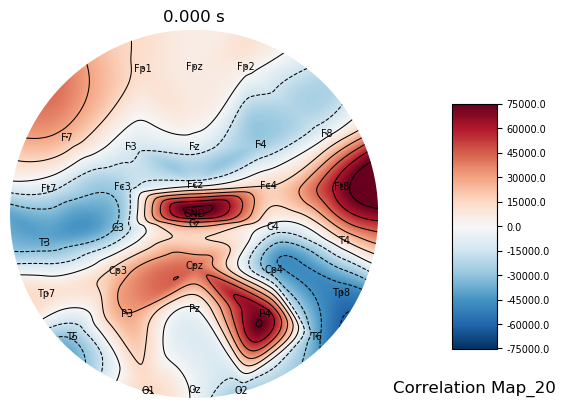

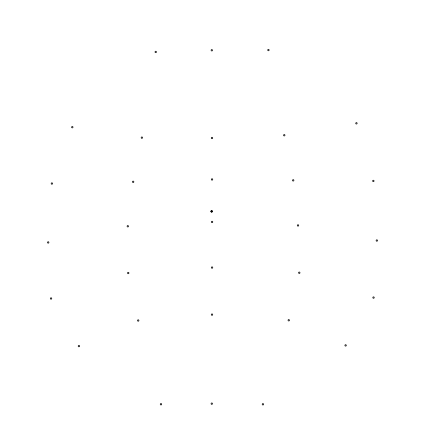

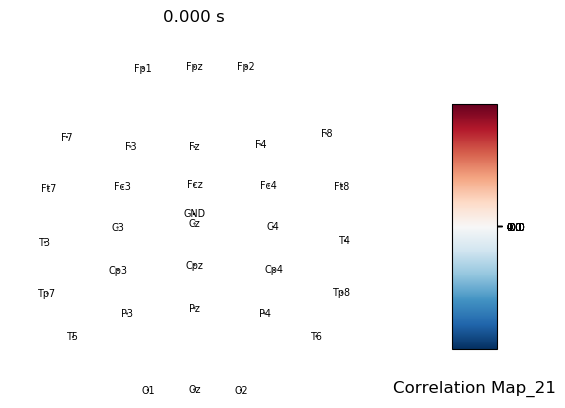

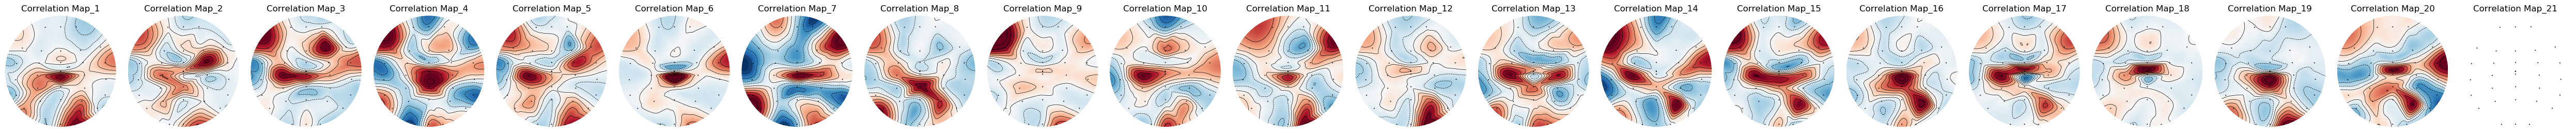

In [12]:
combined_array3 = np.column_stack((sorted_channel_names, ISC_persecond))
# List of channel names

sorted_indices3 = [np.where(combined_array3[:, 0] == ch)[0][0] for ch in channel_names]
sorted_array2 = combined_array3[sorted_indices3]


# Constructing Montage
montage = mne.channels.make_dig_montage(
    ch_pos={name: pos for name, pos in zip(channel_names, positions)},
    coord_frame='head'
)

# Creating an Info object
info = mne.create_info(ch_names=channel_names, sfreq=1000, ch_types='eeg')
info.set_montage(montage)


# Verifying data existence in the array
print("First few rows of data:")
print(sorted_array2[:5])

# Loop to iterate over each data column and generate/save the plot
for i in range(1, sorted_array2.shape[1]):  # Start from 1 to ignore the names column
    data = sorted_array2[:, i].astype(float)

    # Creating an EvokedArray object
    evoked = mne.EvokedArray(data.reshape(-1, 1), info)

    # Generating a topographic plot
    fig, ax = plt.subplots()
    mne.viz.plot_topomap(data, evoked.info, axes=ax, show=False,)
    evoked.plot_topomap(time_unit='s', times=[0], show_names=True, size=3, res=2048, contours=10, show=False,)
    plt.title(f'Correlation Map_{i}', y=-0.1, pad=-14)
    # Saving the plot
    plt.savefig(os.path.join(output_path, f'channel_data_{i}.png'))


# Number of data columns (excluding the names column)
n_columns = sorted_array2.shape[1] - 1

# Creating a figure with multiple subplots
fig = plt.figure(figsize=(50, 10))
gs = gridspec.GridSpec(1, n_columns)

for i in range(1, n_columns + 1):
    ax = fig.add_subplot(gs[0, i - 1])
    data = sorted_array2[:, i].astype(float)

    # Creating an EvokedArray object
    evoked = mne.EvokedArray(data.reshape(-1, 1), info)

    # Generating a topographic plot
    mne.viz.plot_topomap(data, evoked.info, axes=ax, show=False, size = 3, res=1024, contours=10,)
    ax.set_title(f'Correlation Map_{i}')

plt.tight_layout()
plt.savefig(os.path.join(output_path, 'combined_topomaps.png'))
plt.show()
plt.close()